In [1]:
import warnings

warnings.filterwarnings("ignore")

# 4.1 Introduction
* recap:
    * transformers
    * pipeline
    * tuning of pipelines

* next: roadmap!

# 4.2 From sequential to graphical pipelines

Motivation:

Electricity price forecast

* exogeneous features are important
* load forecast, calendar features, weather, ...
* separate forecast for exogeneous (this) and endogeneous (electricity)


### Iteration 1

* only historic data for forecasting
* and a sequential pipeline

For electricity price forecasting a very simple pipeline may look as follows

<img src="../images/sequential-pipeline.png" alt="Sequential Pipelien" width="1000"/>

In [2]:
import pandas as pd

# Load data
data = pd.read_csv(
    "../data/getting_started_data.csv",
    parse_dates=["time"],
    index_col="time",
)
data.index.freq = "H"
y = data["price"]
y_load = data["load_power_statistics"]
y_train = y.iloc[:1000]
X_train_load = y_load.iloc[:1000]
X_test_load = y_load.iloc[1000:1048]

test_idx = y.iloc[1000:1048].index

(<Figure size 1600x400 with 1 Axes>, <AxesSubplot: >)

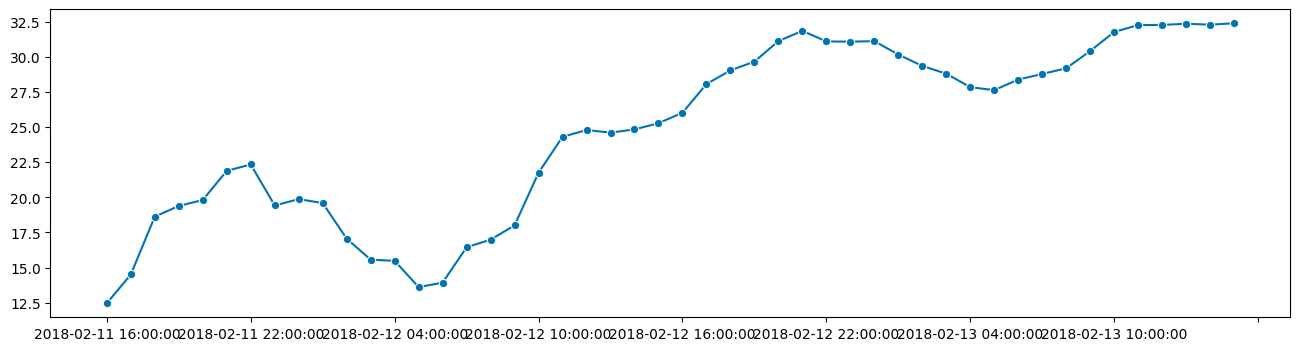

In [3]:
from sktime.forecasting.compose import ForecastingPipeline
from sktime.transformations.series.adapt import TabularToSeriesAdaptor
from sktime.forecasting.base import ForecastingHorizon
from sktime.forecasting.arima import ARIMA
from sklearn.preprocessing import StandardScaler
from sktime.utils.plotting import plot_series

# Build a simple pipeline
pipe = ForecastingPipeline(
    steps=[
        ("standardscaler", TabularToSeriesAdaptor(StandardScaler())),
        ("forecaster", ARIMA(order=(24, 0, 0))),
    ]
)
# Train the pipeline
fh = ForecastingHorizon(test_idx, is_relative=False)
pipe.fit(y_train, fh=fh)

# Predict one Step
y_pred = pipe.predict()
plot_series(y_pred)


### Iteration 2!

* calendar features
* future electrical demand

Requires:
* 2nd pipeline for load forecasting, and
* sticking load forecasts into the price forecasting pipe

#### Load Forecast Pipeline
<img src="../images/LoadForecast.png" alt="Load Forecast" width="1000"/>

#### Price Forecast Pipeline
<img src="../images/PriceForecastAdvanced.png" alt="Price Forecast" width="1000"/>



c:\Users\mf-wa\miniconda3\envs\pydata22\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\mf-wa\miniconda3\envs\pydata22\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(<Figure size 1600x400 with 1 Axes>, <AxesSubplot: >)

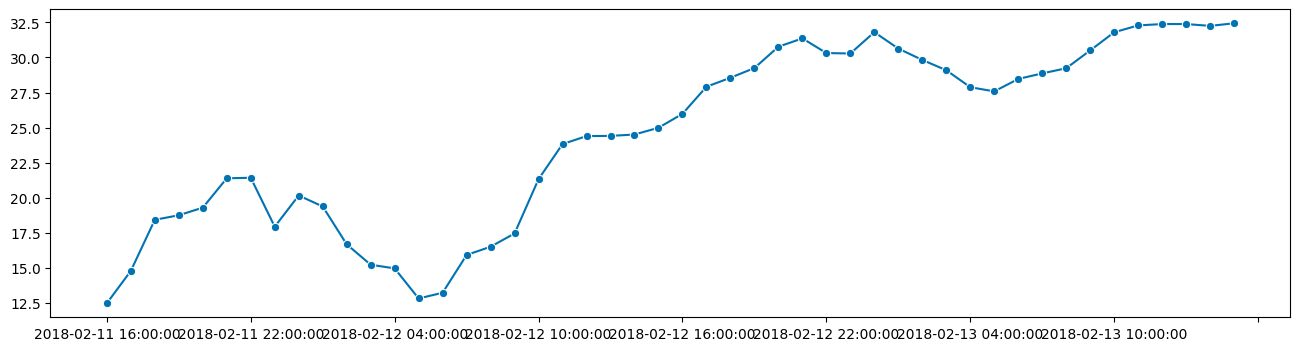

In [4]:
from sktime.transformations.series.date import DateTimeFeatures
from sktime.forecasting.compose import ForecastX

load_pipe = ForecastingPipeline(
    steps=[
        ("standardscaler", TabularToSeriesAdaptor(StandardScaler())),
        ("forecaster", ARIMA((24, 0, 0))),
    ]
)

# Construct a price forecasting pipeline
price_pipe = ForecastingPipeline(
    steps=[
        ("standardscaler", TabularToSeriesAdaptor(StandardScaler())),
        ("forecaster", ARIMA((24, 0, 0))),
    ]
)

dt_features_train = DateTimeFeatures(
    ts_freq="H", manual_selection=["hour_of_day", "day_of_week"]
).fit_transform(X_train_load)[["hour_of_day", "day_of_week"]]
dt_features_test = DateTimeFeatures(
    ts_freq="H", manual_selection=["hour_of_day", "day_of_week"]
).fit_transform(X_test_load)[["hour_of_day", "day_of_week"]]

price_forecast = ForecastX(price_pipe, load_pipe)
price_forecast.fit(y_train, X=dt_features_train, fh=X_test_load.index)
predicted_price = price_forecast.predict(X=dt_features_test)

plot_series(predicted_price)

or, using compositors...

In [5]:
from sktime.transformations.series.date import DateTimeFeatures
from sktime.forecasting.compose import ForecastX

load_pipe = ForecastingPipeline(
    steps=[
        ("standardscaler", TabularToSeriesAdaptor(StandardScaler())),
        ("forecaster", ARIMA((24, 0, 0))),
    ]
)

# Construct a price forecasting pipeline
price_pipe = ForecastingPipeline(
    steps=[
        ("standardscaler", TabularToSeriesAdaptor(StandardScaler())),
        ("forecaster", ARIMA((24, 0, 0))),
    ]
)

dt_features = DateTimeFeatures(
    ts_freq="H", manual_selection=["hour_of_day", "day_of_week"]
)

price_forecast = dt_features ** ForecastX(price_pipe, dt_features ** load_pipe)

In [6]:
price_forecast.fit(y_train, X=X_train_load, fh=X_test_load.index)
predicted_price = price_forecast.predict(X=X_test_load)

c:\Users\mf-wa\miniconda3\envs\pydata22\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\mf-wa\miniconda3\envs\pydata22\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\mf-wa\miniconda3\envs\pydata22\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


this works but ...

* was kind of non-obvious to specify!
* duplication of `dt_features` in specification
* `X_test_load` needs to be passed - can be nan but unintuitive
* quite nested, `get_params` is complicated

In [7]:
price_forecast.get_params()
# let's better hope we don't need to tune this...

{'steps': [DateTimeFeatures(manual_selection=['hour_of_day', 'day_of_week'], ts_freq='H'),
  ForecastX(forecaster_X=ForecastingPipeline(steps=[('DateTimeFeatures',
                                                     DateTimeFeatures(manual_selection=['hour_of_day',
                                                                                        'day_of_week'],
                                                                      ts_freq='H')),
                                                    ('standardscaler',
                                                     TabularToSeriesAdaptor(transformer=StandardScaler())),
                                                    ('forecaster',
                                                     ARIMA(order=(24, 0, 0)))]),
            forecaster_y=ForecastingPipeline(steps=[('standardscaler',
                                                     TabularToSeriesAdaptor(transformer=StandardScaler())),
                                      

## 4.3 Graphical Pipelines aka Non-Sequential Pipelines

benefits:

* clearer specification language - graph formalism
* clearer tuning due to shallow nesting
* shared preprocessing instances, estimator elements, etc

### what are Graphical Pipelines?

* arbitrary branching of data flows (calendar features are used by multiple different forecasts)
* merging of data flows (output of calendar feature extraction and load forecasting are used by the price forecast)
* in/out arrows can refer to the same estimator element

### Non-Sequential Eletrical Price Forecast Pipeline with Ensembles
<img src="../images/NonSequentialPipelineSimple.png" alt="Non Sequential Pipelien" width="1000"/>


* List of further examplary use-cases on [GitHub](https://github.com/sktime/sktime/issues/3023)
    * Wind power generation forecast with hand-crafted feature extraction
    * Theta-Forecaster

### Roadmap for development - `sktime` meets `pyWATTS`!

#### `sktime` -> unified estimator interface, forecasters, composition, sklearn compatible!

#### [`pyWATTS`](https://github.com/KIT-IAI/pyWATTS) -> non-seq pipeline interface for transformers!

* prototype design in [pyWATTS-sktime collab repo](https://github.com/KIT-IAI/pywatts-pipeline)
* design study is performed [here](https://github.com/sktime/sktime/pull/3026#issuecomment-1239648856)

#### many interesting open questions - research and software eng!

* collected in this [issue](https://github.com/sktime/sktime/issues/2653)

#### join us, work with us on graph/nonseq pipelines!

# 5 Summary - `sktime` transformers and pipelines

- time-series models and tools to quickly and easily deploy them

- unified interface design maks it easy to try out different estimators, same vignette

- composition to build pipelines from estimators and transformers - also under unified interface

- rich tools for feature extraction, pipeline building, tuning, autoML

- easy to extend via extension templates, add your own estimators

# Join sktime!

* openly governed, approx equal academia/industry/early career split
    * 18 core developers
    * community council, representative governance
* NumFOCUS-affiliated, affiliated academic centers in UK (and expanding)

**EVERYONE CAN JOIN! EVERYONE CAN BECOME A COMMUNITY LEADER!**

* join our slack (developers) and discord (events)!
    * regular **community collaboration sessions** and stand-ups on Fridays
    * multiple **Dev Sprints and Dev Days** per year

Opportunities:

* regular **job opportunities**, watch the jobs channel
* sktime **mentoring programme**: github.com/sktime/mentoring

## Thank you for your attention

<img src="../images/team.jpg" alt="Sktime Logo" width="1000"/>



---

### Credits: notebook 4 - roadmap, sequential pipelines

notebook creation: benheid

[`pyWATTS`](https://github.com/KIT-IAI/pyWATTS): pywatts team, KIT-IAI\
`DateTimeFeatures`: danbartl\
various pipeline elements: mloning, aiwalter, fkiraly

electricity data set: freely available on [OPSD Platform](https://open-power-system-data.org/)

---

### Credits: sktime

#### many thanks to [all `sktime` contributors!](https://www.sktime.org/en/latest/about/contributors.html)

Citations & credits in academic research papers:

`sktime` toolbox:
 [sktime: A unified interface for machine learning with time series](https://arxiv.org/abs/1909.07872)

`sktime` design principles: [Designing machine learning toolboxes: Concepts, principles and patterns](https://arxiv.org/abs/2101.04938)